# 1. Install Dependencies and Setup

In [ ]:
# !pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dropout, ReLU, MaxPool2D, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from keras.utils import to_categorical

import os
from tqdm.notebook import tqdm
tqdm.pandas()

import cv2
import imghdr
from struct import unpack

import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [3]:
data_dir = 'data' 

In [4]:
marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break   

bads = []
for image_class in tqdm(os.listdir(data_dir)): 
    for image in tqdm(os.listdir(os.path.join(data_dir, image_class))):
        image_path = os.path.join(data_dir, image_class, image)
        image = JPEG(image_path) 
        try:
            image.decode()   
        except:
            bads.append(image_path)  

print(len(bads))

# for name in bads:
#     os.remove(os.path.join(name))


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

0


In [5]:
image_exts = ['jpeg','jpg', 'png']


for image_class in tqdm(os.listdir(data_dir)): 
# for image_class in os.listdir(data_dir): 
    print(image_class)
    for image in tqdm(os.listdir(os.path.join(data_dir, image_class))):
    # for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)

        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)

        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

  0%|          | 0/2 [00:00<?, ?it/s]

happy


  0%|          | 0/153 [00:00<?, ?it/s]

sad


  0%|          | 0/152 [00:00<?, ?it/s]

# 3. Load Data

In [3]:
data = tf.keras.utils.image_dataset_from_directory('data', batch_size = 12, label_mode='categorical', image_size=(150,150))
# data = tf.keras.utils.image_dataset_from_directory('data', batch_size = 16, image_size=(128,128))

Found 600 files belonging to 2 classes.


In [4]:
data_iterator = data.as_numpy_iterator()

In [5]:
batch = data_iterator.next()

c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


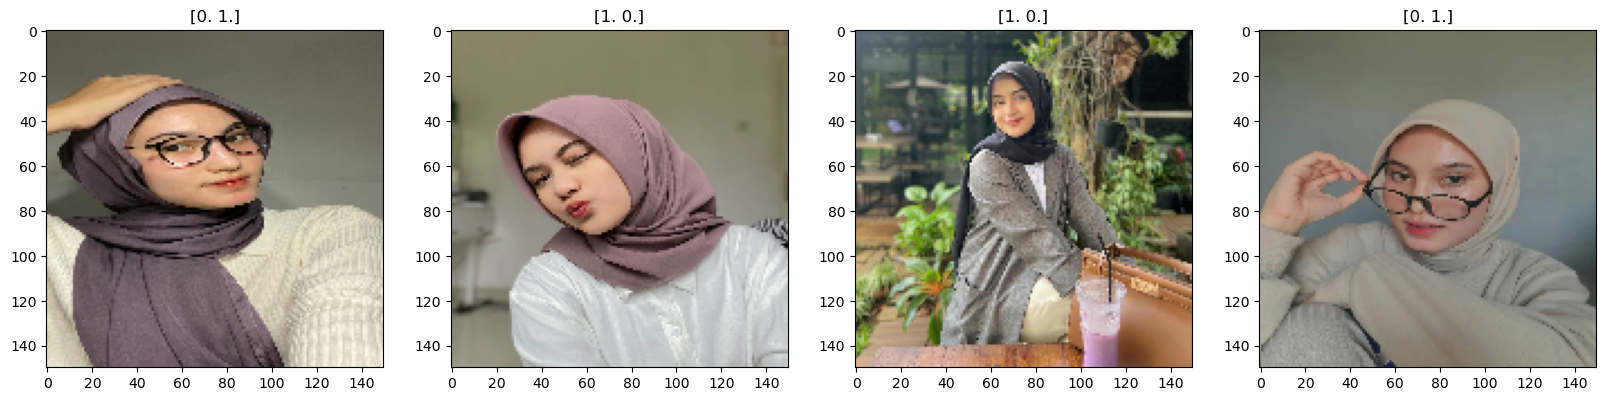

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [7]:
data = data.map(lambda x,y: (x/255, y))

In [8]:
data.as_numpy_iterator().next()

(array([[[[0.7405046 , 0.71305364, 0.67383796],
          [0.7440261 , 0.71657515, 0.67735946],
          [0.7249673 , 0.6975163 , 0.65830064],
          ...,
          [0.9457124 , 0.9064967 , 0.8712026 ],
          [0.975877  , 0.93273973, 0.9099954 ],
          [0.8130213 , 0.8108202 , 0.7950813 ]],
 
         [[0.71369416, 0.6862432 , 0.6470275 ],
          [0.72315294, 0.69570196, 0.6564862 ],
          [0.72862744, 0.70117646, 0.6619608 ],
          ...,
          [0.9303529 , 0.89137256, 0.85607845],
          [0.9622255 , 0.93430394, 0.89621764],
          [0.8691659 , 0.8200672 , 0.796232  ]],
 
         [[0.72383004, 0.69637907, 0.6571634 ],
          [0.7249543 , 0.6975033 , 0.65828764],
          [0.74169934, 0.71424836, 0.6750327 ],
          ...,
          [0.9324183 , 0.8971242 , 0.86183006],
          [0.97424835, 0.9546405 , 0.9381692 ],
          [0.9674513 , 0.9299349 , 0.8946408 ]],
 
         ...,
 
         [[0.10359557, 0.530746  , 0.41702053],
          [0.14430

# 5. Split Data

In [9]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

print(train_size)
print(val_size)
print(test_size)

35
10
5


In [10]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [13]:
model = Sequential()

model.add(Conv2D(64, (3,3), 1, padding='same', activation="relu", input_shape=(150,150,3)))
model.add(Conv2D(64, (3,3), 1, padding='same', activation="relu"))
# model.add(LeakyReLU(0.3))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), 1, padding='same', activation="relu"))
model.add(Conv2D(128, (3,3), 1, padding='same', activation="relu"))
# model.add(LeakyReLU(0.3))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

model.add(Conv2D(256, (3,3), 1, padding='same', activation="relu"))
# model.add(LeakyReLU(0.3))
model.add(Conv2D(256, (3,3), 1, padding='same', activation="relu"))
# model.add(LeakyReLU(0.3))
model.add(Conv2D(256, (3,3), 1, padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

model.add(Conv2D(512, (3,3), 1, padding='same', activation="relu"))
# model.add(LeakyReLU(0.3))
model.add(Conv2D(512, (3,3), 1, padding='same', activation="relu"))
# model.add(LeakyReLU(0.3))
model.add(Conv2D(512, (3,3), 1, padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

model.add(Conv2D(512, (3,3), 1, padding='same', activation="relu"))
# model.add(LeakyReLU(0.3))
model.add(Conv2D(512, (3,3), 1, padding='same', activation="relu"))
# model.add(LeakyReLU(0.3))
model.add(Conv2D(512, (3,3), 1, padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1000, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

opt = Adam(learning_rate = 0.01)

# model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 150, 150, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 75, 75, 128)       73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 75, 75, 128)       147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 37, 37, 128)      0         
 2D)                                                  

In [74]:
# model = Sequential()

# model.add(Conv2D(128, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same',  input_shape=(256,256,3)))
# model.add(MaxPooling2D())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# model.add(Conv2D(64, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# model.add(Conv2D(64, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# model.add(Conv2D(32, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# # model.add(Conv2D(32, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
# # model.add(MaxPooling2D())
# # model.add(Dropout(0.4))
# # model.add(BatchNormalization())

# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# # model.add(Dense(256, activation='relu'))
# # model.add(Dropout(0.2))

# model.add(Dense(4, activation='softmax'))

# opt = Adam(learning_rate = 0.001)
# loss = tf.keras.losses.SparseCategoricalCrossentropy()

# model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 256, 256, 128)     3584      
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 128, 128, 128)    0         
 g2D)                                                            
                                                                 
 dropout_119 (Dropout)       (None, 128, 128, 128)     0         
                                                                 
 batch_normalization_74 (Bat  (None, 128, 128, 128)    512       
 chNormalization)                                                
                                                                 
 conv2d_75 (Conv2D)          (None, 128, 128, 64)      73792     
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 64, 64, 64)     

In [15]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])


# 7. Train

In [16]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
35/35 [==============================] - 3s 53ms/step - loss: 0.6855 - accuracy: 0.5381 - val_loss: 0.6303 - val_accuracy: 0.5750
Epoch 2/10
35/35 [==============================] - 2s 61ms/step - loss: 0.6188 - accuracy: 0.6571 - val_loss: 0.5375 - val_accuracy: 0.7333
Epoch 3/10
35/35 [==============================] - 2s 61ms/step - loss: 0.4657 - accuracy: 0.7714 - val_loss: 0.4857 - val_accuracy: 0.7583
Epoch 4/10
35/35 [==============================] - 2s 61ms/step - loss: 0.2741 - accuracy: 0.8929 - val_loss: 0.3869 - val_accuracy: 0.8167
Epoch 5/10
35/35 [==============================] - 2s 62ms/step - loss: 0.2377 - accuracy: 0.9048 - val_loss: 0.4282 - val_accuracy: 0.7917
Epoch 6/10
35/35 [==============================] - 2s 60ms/step - loss: 0.1634 - accuracy: 0.9357 - val_loss: 0.3768 - val_accuracy: 0.8417
Epoch 7/10
35/35 [==============================] - 2s 63ms/step - loss: 0.1251 - accuracy: 0.9643 - val_loss: 0.2724 - val_accuracy: 0.8667
Epoch 8/10
35

# 8. Plot Performance

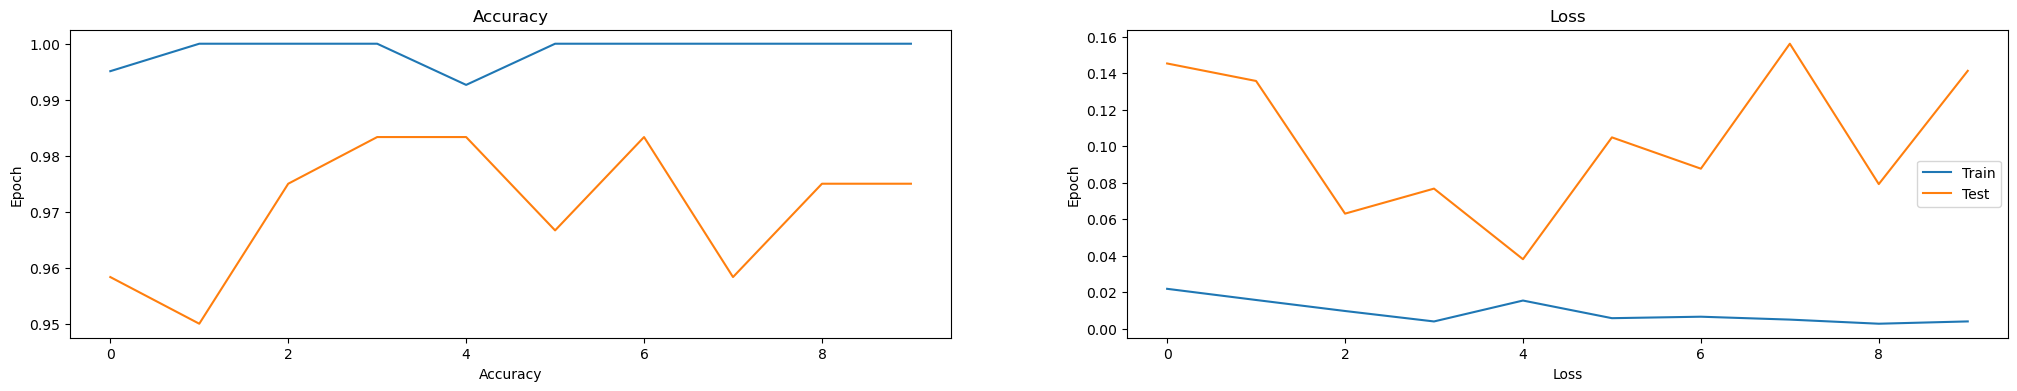

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(hist.history['accuracy'])
ax[0].plot(hist.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(hist.history['loss'])
ax[1].plot(hist.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

# 9. Evaluate

In [32]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [33]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 19ms/step


In [35]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [36]:
import cv2

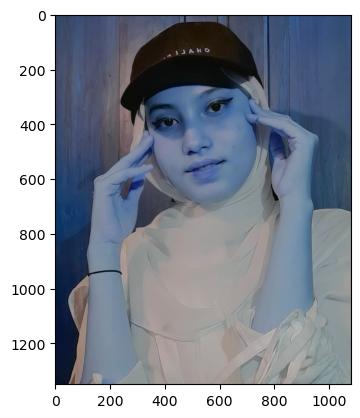

In [50]:
img = cv2.imread('2021-06-10_02-41-21_UTC_4.jpg')
plt.imshow(img)
plt.show()

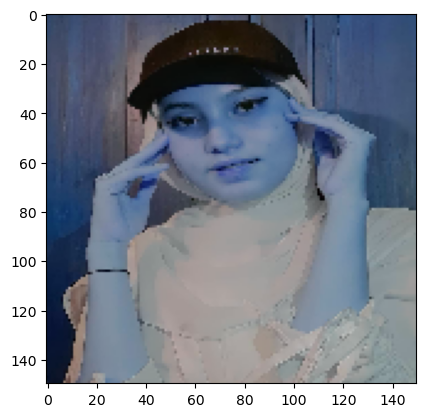

In [51]:
resize = tf.image.resize(img, (150,150))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [52]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 15ms/step


In [53]:
yhat.argmax()

1

In [49]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','imageclassifier.h5'))

In [46]:
new_model = load_model('imageclassifier.h5')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)